# Data

## Load the data

In [1]:
"""
    Download and save raw market data CSV
"""

import pandas as pd
import logging
import os

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Download and save CSV. One time only
logger.info("Downloading power data...")
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
local_path = "data/power_data_raw.csv"

os.makedirs("data", exist_ok=True)

if os.path.exists(local_path):
    logger.info("File exists. Reading local CSV...")
    df = pd.read_csv(local_path)
else:
    df = pd.read_csv(url)
    logger.info("Saving to data/power_data_raw.csv")
    os.makedirs("data", exist_ok=True)
    df.to_csv("data/power_data_raw.csv", index=False)

logger.info("Process completed.")

2025-12-02 21:57:34,073 | INFO | Downloading power data...
2025-12-02 21:57:34,074 | INFO | File exists. Reading local CSV...
2025-12-02 21:57:34,523 | INFO | Process completed.


## Get Austria's Values

In [2]:
print(df.head())
with open("data/all_column_names.txt", "w") as f:
    for col in df.columns:
        f.write(f"{col}\n")

          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Columns: 300 entries, utc_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(2)
memory usage: 115.4+ MB


In [4]:
at_cols = df.columns[df.columns.str.startswith("AT_")]
selected_cols = ["utc_timestamp"] + list(at_cols) # Desired Columns
df_selected = df[selected_cols].copy()
df_selected = df_selected.drop(["AT_load_forecast_entsoe_transparency", "AT_solar_generation_actual", "AT_load_forecast_entsoe_transparency"], axis=1)
df_selected["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"]) # Datetime Timestamp
df_selected = df_selected.set_index("utc_timestamp") # Timestamp as index
print(df_selected.head(1))

                           AT_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   

                           AT_price_day_ahead  \
utc_timestamp                                   
2014-12-31 23:00:00+00:00                 NaN   

                           AT_wind_onshore_generation_actual  
utc_timestamp                                                 
2014-12-31 23:00:00+00:00                                NaN  


### Enforce Frequency and Clean Dataset

#### Enforce Frequency

In [5]:
full_idx = pd.date_range(
    start=df_selected.index.min(),
    end=df_selected.index.max(),
    freq="h",
    tz=df_selected.index.tz
)
df_selected = df_selected.reindex(full_idx)

In [6]:
important_cols = ["AT_load_actual_entsoe_transparency", "AT_price_day_ahead", "AT_wind_onshore_generation_actual"]

In [7]:
first_valid_indices = df_selected[important_cols].apply(lambda col: col.first_valid_index())
last_valid_indices = df_selected[important_cols].apply(lambda col: col.last_valid_index())

print("First valid data points:")
print(first_valid_indices)

First valid data points:
AT_load_actual_entsoe_transparency   2015-01-01 00:00:00+00:00
AT_price_day_ahead                   2015-01-01 00:00:00+00:00
AT_wind_onshore_generation_actual    2015-01-01 00:00:00+00:00
dtype: datetime64[ns, UTC]


In [8]:
print(last_valid_indices)

AT_load_actual_entsoe_transparency   2020-09-30 23:00:00+00:00
AT_price_day_ahead                   2018-10-02 21:00:00+00:00
AT_wind_onshore_generation_actual    2020-09-30 23:00:00+00:00
dtype: datetime64[ns, UTC]


In [9]:
global_start = first_valid_indices.max()
global_end = last_valid_indices.min()

print(f"\nSlicing Data to Common Range: {global_start} to {global_end}")


Slicing Data to Common Range: 2015-01-01 00:00:00+00:00 to 2018-10-02 21:00:00+00:00


In [10]:
df_clean = df_selected.loc[global_start: global_end].copy()
print(df_clean.isna().sum())

AT_load_actual_entsoe_transparency     0
AT_price_day_ahead                    57
AT_wind_onshore_generation_actual     48
dtype: int64


In [11]:
def get_max_consecutive_nans(series):
    # Create a boolean mask where True is NaN
    mask = series.isna()
    # Group consecutive True/False values and count them
    # We only keep the groups that are NaN (True)
    consecutive_counts = mask.groupby((mask != mask.shift()).cumsum()).sum()
    # Return the max
    return consecutive_counts[mask.groupby((mask != mask.shift()).cumsum()).first()].max()

# Apply to your important columns
for col in important_cols:
    max_gap = get_max_consecutive_nans(df_clean[col])
    print(f"{col}: Max consecutive NaNs = {max_gap}")

AT_load_actual_entsoe_transparency: Max consecutive NaNs = nan
AT_price_day_ahead: Max consecutive NaNs = 24
AT_wind_onshore_generation_actual: Max consecutive NaNs = 24


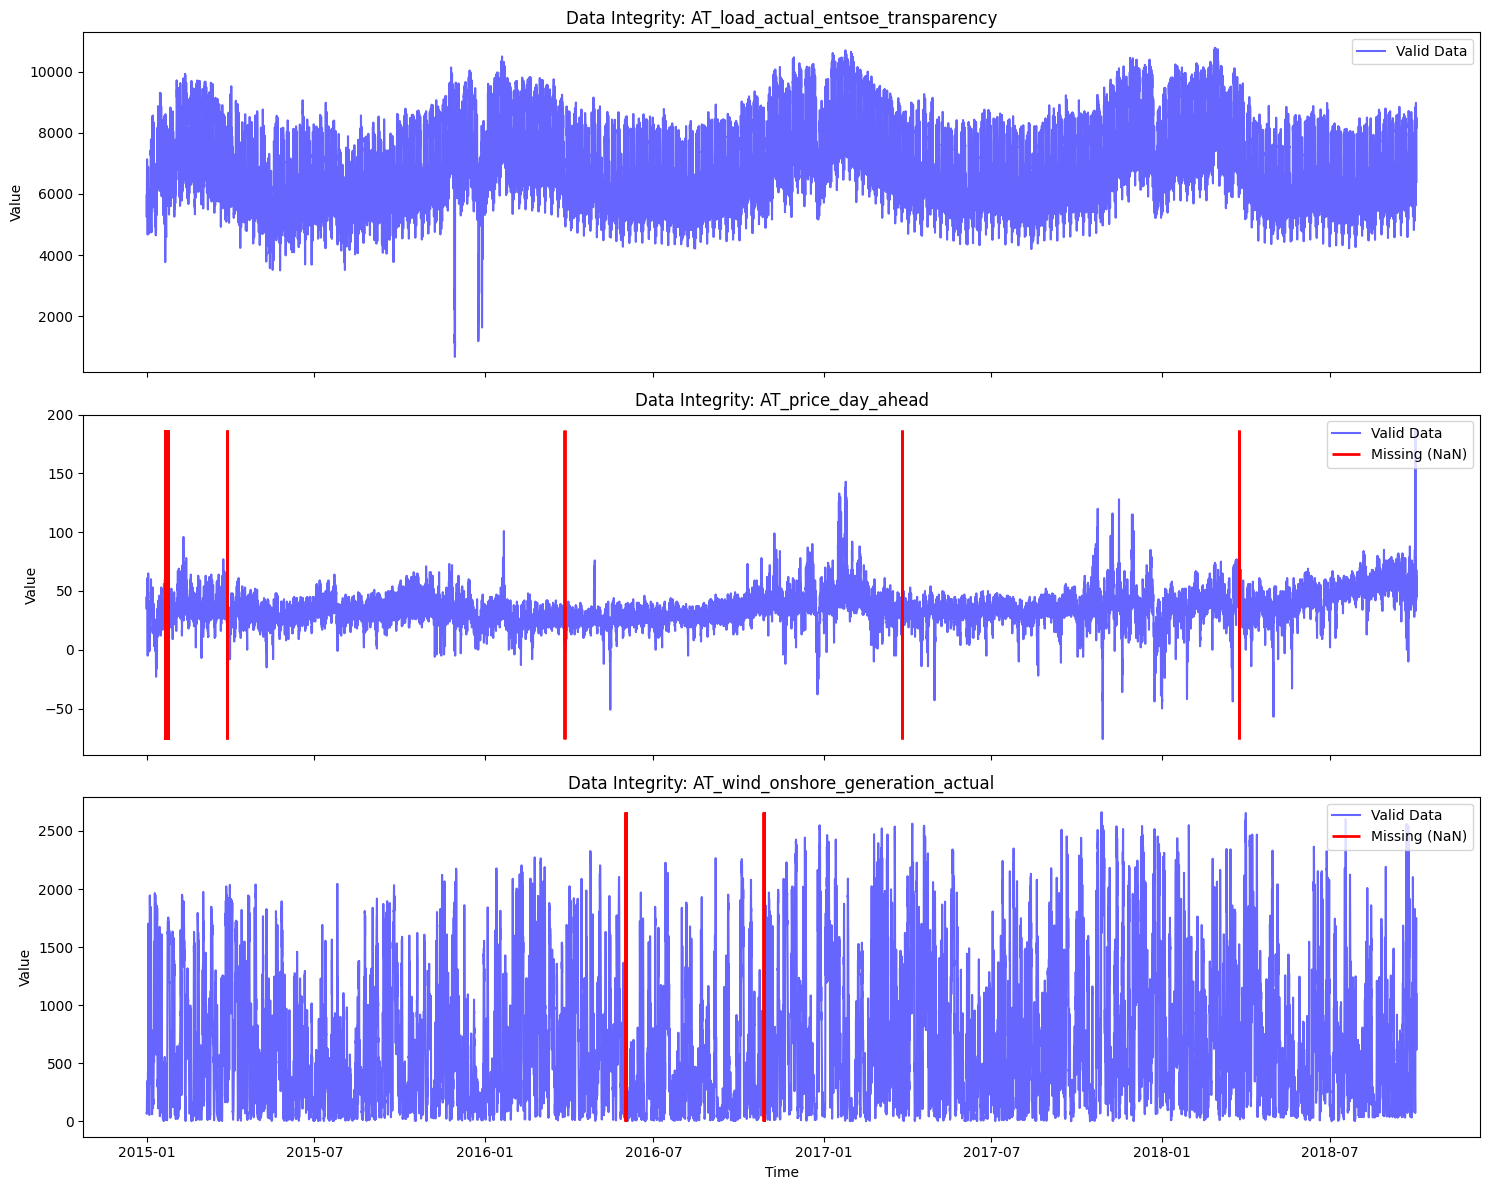

In [12]:
import matplotlib.pyplot as plt

# The columns we care about
cols_to_check = [
    'AT_load_actual_entsoe_transparency',
    'AT_price_day_ahead',
    'AT_wind_onshore_generation_actual'
]

# Create a figure with 3 subplots (one for each column)
fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=1, figsize=(15, 12), sharex=True)

for i, col in enumerate(cols_to_check):
    # 1. Get data
    valid_data = df_clean[col]
    missing_data = df_clean[df_clean[col].isna()]
    
    # 2. Calculate ranges for plotting
    d_min = valid_data.min()
    d_max = valid_data.max()
    
    # 3. Plot Valid Data
    axes[i].plot(valid_data.index, valid_data, label="Valid Data", color="blue", alpha=0.6)
    
    # 4. Plot Missing Data (The Red Stripes)
    if len(missing_data) > 0:
        axes[i].vlines(
            x=missing_data.index, 
            ymin=d_min, 
            ymax=d_max, 
            colors="red", 
            linewidth=2, 
            label="Missing (NaN)"
        )
    
    axes[i].set_title(f"Data Integrity: {col}")
    axes[i].set_ylabel("Value")
    axes[i].legend(loc="upper right")

plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [13]:
df_clean['AT_wind_onshore_generation_actual'] = pd.to_numeric(
    df_clean['AT_wind_onshore_generation_actual'], 
    errors='coerce'
)

In [ ]:
# Custom function to fill NaNs with the value from the same hour 24 hours ago
def fill_with_seasonal_pattern(df, cols, period=24):
    df_filled = df.copy()
    for col in cols:
        # Fill forward
        df_filled[col] = df_filled[col].fillna(df_filled[col].shift(period))
        # If gaps remain (e.g., start of dataset), fill backward (take from tomorrow)
        df_filled[col] = df_filled[col].fillna(df_filled[col].shift(-period))
    return df_filled

# First fill yesterday's values
df_clean = fill_with_seasonal_pattern(df_clean, important_cols, period=24)

print(df_clean.isna().sum())

# Any remaining small gaps can be safely linearly interpolated (Use forward direction for time series)
df_clean[important_cols] = df_clean[important_cols].interpolate(method="linear", limit_direction="forward")

print(df_clean.isna().sum())

AT_load_actual_entsoe_transparency    0
AT_price_day_ahead                    0
AT_wind_onshore_generation_actual     0
dtype: int64
AT_load_actual_entsoe_transparency    0
AT_price_day_ahead                    0
AT_wind_onshore_generation_actual     0
dtype: int64


## Feature Engineering

### Lagged price (previous hour)

In [15]:
df_clean["AT_price_day_ahead_lag1"] = df_clean["AT_price_day_ahead"].shift(1)

### 24-hour SMA and 24-hour EMA for load

In [16]:
df_clean["AT_load_rolling24h"] = df_clean["AT_load_actual_entsoe_transparency"].rolling(window=24).mean()
df_clean["AT_load_ema24h"] = df_clean["AT_load_actual_entsoe_transparency"].ewm(span=24, adjust=False).mean()

### Hour and weekday

In [17]:
df_clean["hour"] = df_clean.index.hour
df_clean["weekday"] = df_clean.index.dayofweek

In [18]:
df_clean.head(30)

,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_generation_actual,AT_price_day_ahead_lag1,AT_load_rolling24h,AT_load_ema24h,hour,weekday
2015-01-01 00:00:00+00:00,5946.0,35.0,69.0,NaN,NaN,5946.000000,0,3
2015-01-01 01:00:00+00:00,5726.0,45.0,64.0,35.0,NaN,5928.400000,1,3
2015-01-01 02:00:00+00:00,5347.0,41.0,65.0,45.0,NaN,5881.888000,2,3
2015-01-01 03:00:00+00:00,5249.0,38.0,64.0,41.0,NaN,5831.256960,3,3
2015-01-01 04:00:00+00:00,5309.0,35.0,64.0,38.0,NaN,5789.476403,4,3
2015-01-01 05:00:00+00:00,5574.0,35.0,84.0,35.0,NaN,5772.238291,5,3
2015-01-01 06:00:00+00:00,5925.0,36.0,131.0,35.0,NaN,5784.459228,6,3
2015-01-01 07:00:00+00:00,6343.0,36.0,109.0,36.0,NaN,5829.142489,7,3
2015-01-01 08:00:00+00:00,6882.0,41.0,146.0,36.0,NaN,5913.371090,8,3
2015-01-01 09:00:00+00:00,6963.0,45.0,146.0,41.0,NaN,5997.341403,9,3


In [19]:
df_clean.tail(30)

,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_generation_actual,AT_price_day_ahead_lag1,AT_load_rolling24h,AT_load_ema24h,hour,weekday
2018-10-01 16:00:00+00:00,8823.0,73.0,1177.0,66.0,7262.375000,7622.682068,16,0
2018-10-01 17:00:00+00:00,8517.0,187.0,1263.0,73.0,7334.416667,7694.227503,17,0
2018-10-01 18:00:00+00:00,7968.0,75.0,1324.0,187.0,7394.208333,7716.129303,18,0
2018-10-01 19:00:00+00:00,7203.0,67.0,1269.0,75.0,7441.291667,7675.078958,19,0
2018-10-01 20:00:00+00:00,6836.0,59.0,1150.0,67.0,7472.333333,7607.952642,20,0
2018-10-01 21:00:00+00:00,6314.0,52.0,1221.0,59.0,7497.708333,7504.436430,21,0
2018-10-01 22:00:00+00:00,6026.0,38.0,1464.0,52.0,7520.208333,7386.161516,22,0
2018-10-01 23:00:00+00:00,5792.0,38.0,1316.0,38.0,7542.375000,7258.628595,23,0
2018-10-02 00:00:00+00:00,5698.0,37.0,1201.0,38.0,7563.250000,7133.778307,0,1
2018-10-02 01:00:00+00:00,5629.0,33.0,1337.0,37.0,7584.416667,7013.396043,1,1


In [20]:
df_clean = df_clean.dropna()
df_final = df_clean.copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32879 entries, 2015-01-01 23:00:00+00:00 to 2018-10-02 21:00:00+00:00
Freq: h
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   AT_load_actual_entsoe_transparency  32879 non-null  float64
 1   AT_price_day_ahead                  32879 non-null  float64
 2   AT_wind_onshore_generation_actual   32879 non-null  float64
 3   AT_price_day_ahead_lag1             32879 non-null  float64
 4   AT_load_rolling24h                  32879 non-null  float64
 5   AT_load_ema24h                      32879 non-null  float64
 6   hour                                32879 non-null  int32  
 7   weekday                             32879 non-null  int32  
dtypes: float64(6), int32(2)
memory usage: 2.0 MB


In [21]:
print(df_final.index.is_monotonic_increasing)
print(df_final.index.has_duplicates)
print(df_final.index.inferred_freq)
print(df_final.index.freq)

diffs = df_final.index.to_series().diff().value_counts()
print(diffs.head())

True
False
h
<Hour>
0 days 01:00:00    32878
Name: count, dtype: int64


### Split the data

In [22]:
TEST_WEEKS = 2
TEST_HOURS = 24 * 7 * TEST_WEEKS

split_cutoff_index = len(df_final) - TEST_HOURS
split_date = df_final.index[split_cutoff_index]

logger.info(f"Training Data Ends: {split_date}")
logger.info(f"Test Data Starts: {split_date}")
logger.info(f"Test Duration: {TEST_HOURS} hours")

X_train_master = df_final.iloc[:split_cutoff_index].drop(columns="AT_price_day_ahead")
X_test_master = df_final.iloc[split_cutoff_index:].drop(columns="AT_price_day_ahead")

y_train_master = df_final.iloc[:split_cutoff_index]["AT_price_day_ahead"]
y_test_master = df_final.iloc[split_cutoff_index:]["AT_price_day_ahead"]

2025-12-02 21:57:35,279 | INFO | Training Data Ends: 2018-09-18 22:00:00+00:00
2025-12-02 21:57:35,279 | INFO | Test Data Starts: 2018-09-18 22:00:00+00:00
2025-12-02 21:57:35,280 | INFO | Test Duration: 336 hours


# Modeling

## Training

### Linear regression

#### Training

In [23]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_master, y_train_master)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Testing

In [24]:
y_pred = model.predict(X_test_master) # Test part
y_train_pred = model.predict(X_train_master) # Train part

#### Calculate error metrics

In [25]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [26]:
print("MAE:", mean_absolute_error(y_train_master, y_train_pred)) # Train error
print("RMSE:", root_mean_squared_error(y_train_master, y_train_pred))

MAE: 2.710912811786848
RMSE: 3.821323900018046


In [27]:
print("MAE:", mean_absolute_error(y_test_master, y_pred)) # Prediction error
print("RMSE:", root_mean_squared_error(y_test_master, y_pred))

MAE: 6.057531662033532
RMSE: 11.356407366888186


In [28]:
print(y_test_master)

2018-09-18 22:00:00+00:00    47.0
2018-09-18 23:00:00+00:00    47.0
2018-09-19 00:00:00+00:00    46.0
2018-09-19 01:00:00+00:00    45.0
2018-09-19 02:00:00+00:00    47.0
                             ... 
2018-10-02 17:00:00+00:00    68.0
2018-10-02 18:00:00+00:00    65.0
2018-10-02 19:00:00+00:00    54.0
2018-10-02 20:00:00+00:00    45.0
2018-10-02 21:00:00+00:00    62.0
Freq: h, Name: AT_price_day_ahead, Length: 336, dtype: float64


In [29]:
print(y_pred)

[ 44.62881543  44.03628172  44.71430859  44.3212158   44.17086745
  47.34309187  52.85136189  68.73769698  77.00874476  78.36999012
  75.16154025  69.07794019  63.58940021  56.54066019  52.46006175
  51.10306609  51.72396966  53.41625089  63.60385371  69.05625842
  72.00882761  72.07390237  63.3839436   52.8024351   44.53050233
  41.95861744  41.7431667   39.4767115   40.27109587  44.55700711
  50.18914144  66.87878645  76.98122489  74.47650478  72.17031562
  67.03636864  56.88436283  49.82468489  48.4769983   47.17411329
  49.73851948  51.49987596  63.55571509  71.77952283  73.84646002
  73.03152723  63.42122978  53.70843419  47.33809342  44.7871513
  39.94895623  36.66836973  33.70993739  34.12633656  39.60108485
  54.47402481  58.94847842  54.54998753  50.37985766  43.35282417
  33.1526362   25.03325135  22.81808078  21.57556417  23.14281544
  26.81561944  36.988032    47.14471842  51.10326657  52.18490698
  43.70788455  36.0732833   26.87303701  26.83125405  17.26523439
  10.239360

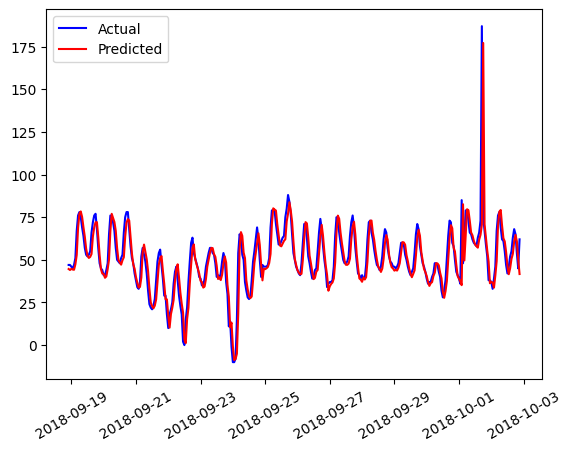

In [30]:
plt.plot(y_test_master.index, y_test_master, label="Actual", color="blue")
plt.plot(y_test_master.index, y_pred, label="Predicted", color="red")
plt.xticks(rotation=30)
plt.legend()
plt.show()

### Cross-validation way

In [31]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_error

In [32]:
tscv = TimeSeriesSplit(n_splits=5) # Split the data into 5 folds
model = LinearRegression()

In [33]:
scores = cross_val_score(
    model, X_train_master, y_train_master, cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

In [34]:
import numpy as np
rmse_scores = np.sqrt(-scores)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())

RMSE scores for each fold: [3.33747824 3.04174469 4.42859048 4.19559053 4.13238167]
Mean RMSE: 3.827157122171589
Std RMSE: 0.5380121519789884


### Manual CV to plot the most representative fold

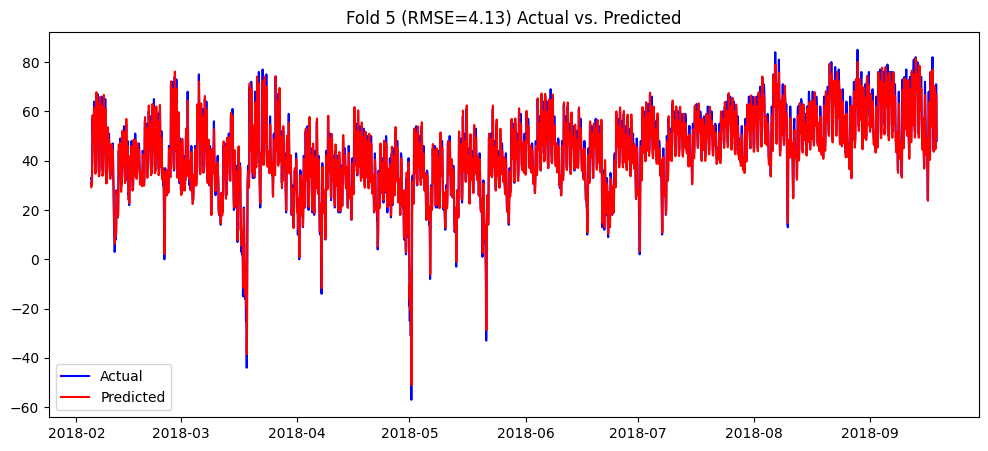

In [35]:
tscv_plot = TimeSeriesSplit(n_splits=5)
model_cv_plot = LinearRegression()

fold_rmse = []
fold_preds = []
fold_indices = []

for train_idx, test_idx in tscv_plot.split(X_train_master):
    model_cv_plot.fit(X_train_master.iloc[train_idx], y_train_master.iloc[train_idx])
    y_pred_fold = model_cv_plot.predict(X_train_master.iloc[test_idx])
    rmse = root_mean_squared_error(y_train_master.iloc[test_idx], y_pred_fold)
    fold_rmse.append(rmse)
    fold_preds.append(y_pred_fold)
    fold_indices.append(test_idx)

mean_rmse = np.mean(fold_rmse)
best_fold = np.argmin(np.abs(np.array(fold_rmse) - mean_rmse))

plt.figure(figsize=(12, 5))
plt.plot(y_train_master.iloc[fold_indices[best_fold]].index, y_train_master.iloc[fold_indices[best_fold]], label="Actual", color="blue")
plt.plot(y_train_master.iloc[fold_indices[best_fold]].index, fold_preds[best_fold], label="Predicted", color="red")
plt.title(f"Fold {best_fold+1} (RMSE={fold_rmse[best_fold]:.2f}) Actual vs. Predicted")
plt.legend()
plt.show()

### Coefficients

#### Raw Coefficients

In [36]:
for feature, coeff in zip(["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_ema24h", "AT_wind_onshore_generation_actual", "hour", "weekday"], model_cv_plot.coef_):
    print(f"{feature}: {coeff}")

AT_price_day_ahead_lag1: 0.0017948128548269978
AT_load_actual_entsoe_transparency: -9.6076139645854e-05
AT_load_ema24h: 0.9273973307222558
AT_wind_onshore_generation_actual: 0.004162861087933709
hour: -0.00576365409310933
weekday: 0.00040033365095059074


#### Normalized Coefficients

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_master)
X_test_scaled = scaler.transform(X_test_master)

model = LinearRegression()
model.fit(X_train_scaled, y_train_master)

for feature, coeff in zip(X_train_master.columns, model.coef_):
    print(f"{feature}: {coeff}")

AT_load_actual_entsoe_transparency: 2.358154190394435
AT_wind_onshore_generation_actual: -0.034976600802459484
AT_price_day_ahead_lag1: 13.941457662543604
AT_load_rolling24h: 3.7581584861894965
AT_load_ema24h: -5.351239331524967
hour: -0.03766398139189689
weekday: 0.0167349386035788


## ARIMA

### Static Forecasting Method

In [38]:
from statsmodels.tsa.arima.model import ARIMA

In [39]:
model_arima = ARIMA(y_train_master, order=(5,1,4))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     AT_price_day_ahead   No. Observations:                32543
Model:                 ARIMA(5, 1, 4)   Log Likelihood              -83914.361
Date:                Tue, 02 Dec 2025   AIC                         167848.722
Time:                        21:57:44   BIC                         167932.625
Sample:                    01-01-2015   HQIC                        167875.539
                         - 09-18-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4103      0.026     15.695      0.000       0.359       0.462
ar.L2          1.0700      0.032     33.313      0.000       1.007       1.133
ar.L3         -0.6571      0.019    -35.476      0.0

In [40]:
# print(train_arima)
print(y_train_master.mean())

33.768275819684725


In [41]:
in_smaple_preds_arima = model_arima_fit.predict()

rmse_arima = root_mean_squared_error(y_train_master, in_smaple_preds_arima)
mae_arima = mean_absolute_error(y_train_master, in_smaple_preds_arima)
print("RMSE: ", rmse_arima)
print("MAE: ", mae_arima)

RMSE:  3.189815245316879
MAE:  2.1141668747397264


In [42]:
out_sample_forecast_arima = model_arima_fit.forecast(steps=len(y_test_master))

rmse_test_arima = root_mean_squared_error(y_test_master, out_sample_forecast_arima)
mae_test_arima = mean_absolute_error(y_test_master, out_sample_forecast_arima)

print("RMSE: ", rmse_test_arima)
print("MAE: ", mae_test_arima)

RMSE:  15.122335805128053
MAE:  10.40829944101597


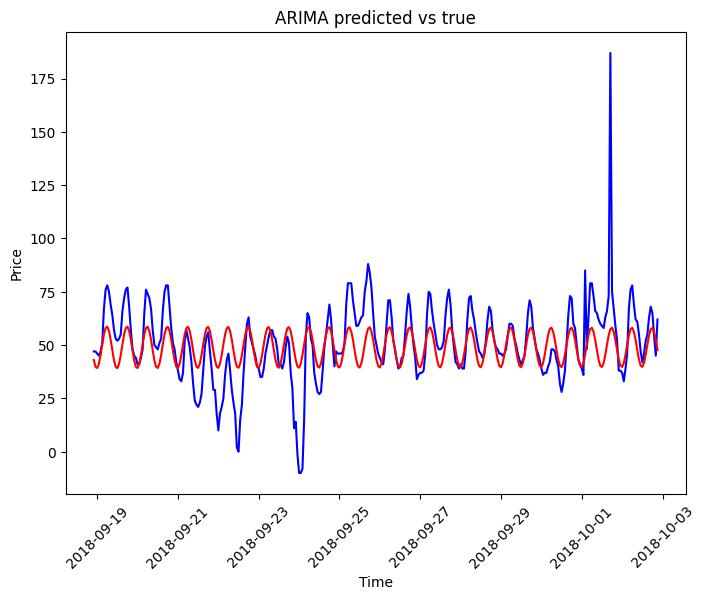

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(y_test_master.index, y_test_master, color="blue")
plt.plot(y_test_master.index, out_sample_forecast_arima, color="red")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("ARIMA predicted vs true")
plt.show()

### Rolling Window Forecasting Method

In [44]:
from pmdarima import auto_arima
auto_model = auto_arima(y_train_master, seasonal=False, trace=True)
print(auto_model.summary())
best_order = auto_model.order
# Fit ARIMA with best_order
model_arima = ARIMA(y_train_master, order=best_order).fit()
out_sample_forecast_arima = model_arima.forecast(steps=len(y_test_master))
out_sample_forecast_arima = pd.Series(out_sample_forecast_arima, index=y_test_master.index)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=171032.756, Time=3.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=186508.253, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=175107.900, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=176683.667, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=186506.255, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=174157.326, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=171053.616, Time=6.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=171012.310, Time=5.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=171031.199, Time=3.79 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=171033.192, Time=6.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=9.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=171024.452, Time=6.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=171021.523, Time=6.40 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=171101.955, Time=14.26 sec
 ARIMA(3,1,

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Starting forecast for 336 hours...
Rolling Forecast RMSE: 16.57
Rolling Forecast MAE: 11.76


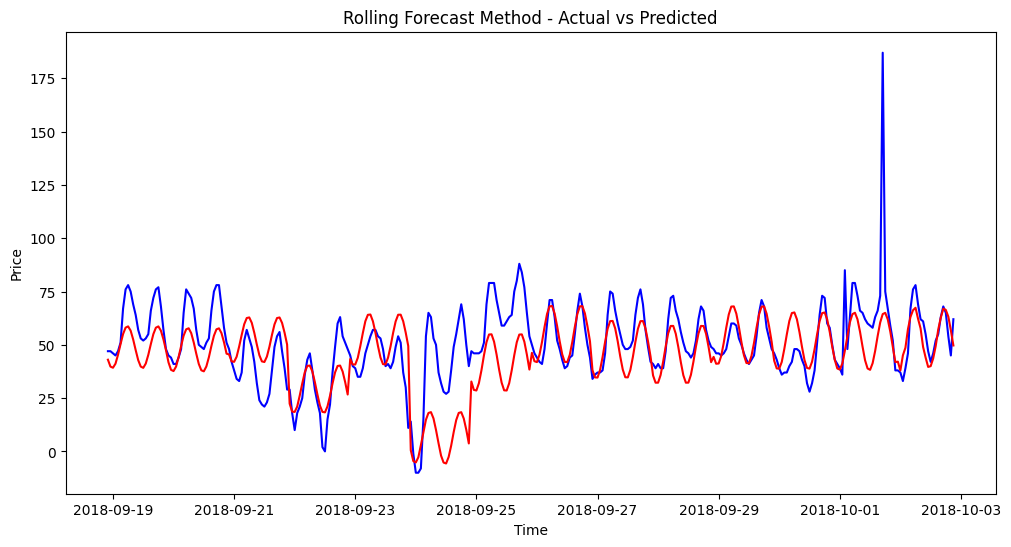

In [45]:
rolling_model = ARIMA(y_train_master, order=(5, 1, 4)).fit()

predictions = []
history = y_train_master.copy()
step_size = 24 # We iterate through the test data in steps of 24 hours (Day-Ahead)

print(f"Starting forecast for {len(y_test_master)} hours...")

for t in range(0, len(y_test_master), step_size):
    forecast = rolling_model.forecast(steps=step_size)

    predictions.extend(forecast)

    true_chunk = y_test_master[t: t + step_size]

    rolling_model = rolling_model.append(true_chunk, refit=False)

predictions = pd.Series(predictions, index=y_test_master.index)

rmse = root_mean_squared_error(y_test_master, predictions)
mae = mean_absolute_error(y_test_master, predictions)

print(f"Rolling Forecast RMSE: {rmse:.2f}")
print(f"Rolling Forecast MAE: {mae:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_master.index,y_test_master, color="blue")
plt.plot(predictions.index, predictions, color="red")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Rolling Forecast Method - Actual vs Predicted")
plt.show()

#### The Rolling ARIMA model established a baseline RMSE of 16.81. While it successfully captured the daily seasonality and general trend, it failed to predict extreme outliers (like the Oct 2nd spike) because standard ARIMA lacks visibility into fundamental drivers like Wind and Load. This justifies the need for an ARIMAX/SARIMAX model or XGBoost to incorporate exogenous features.

### Use Sliding Window on train data (Get rid of stale data)

Starting Sliding Window Forecast (Refitting every 24 hours)...
Window Size: 8760 hours
Test Duration: 336 hours
Predicted step 0/336
Predicted step 24/336
Predicted step 48/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 72/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 96/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 120/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 144/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 168/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 192/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 216/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 240/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 264/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 288/336
Predicted step 312/336
RMSE: 16.97035876344441
MAE: 12.072271729609934


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


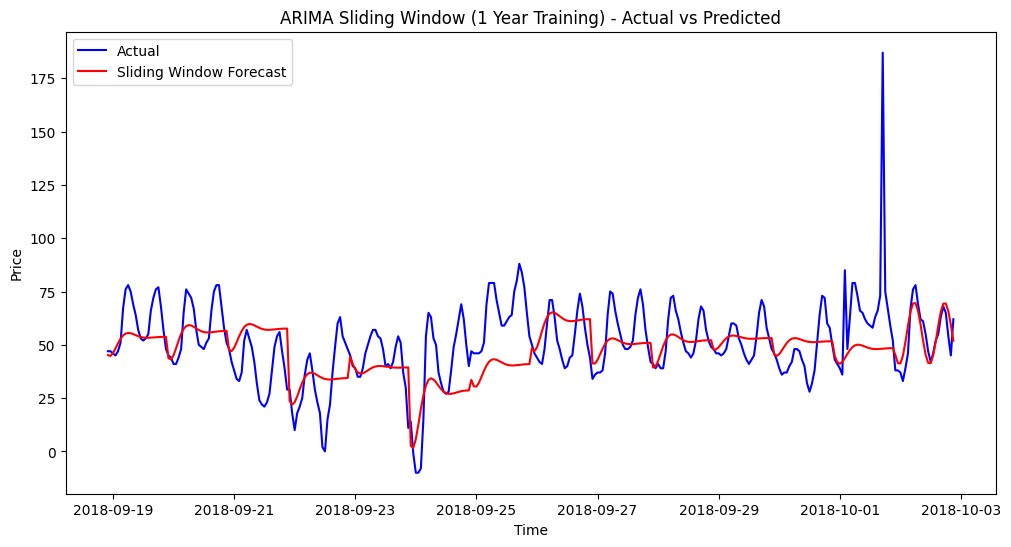

In [46]:
window_size = 24 * 365 # Keep last years data
forecast_horizon = 24 # Predict the next 24 hours
step_size = 24 # Move the window of train data by 24 hours

full_history = pd.concat([y_train_master, y_test_master])

test_start_index = len(y_train_master)
total_steps = len(y_test_master)

predictions = []
actuals = []

print(f"Starting Sliding Window Forecast (Refitting every {step_size} hours)...")
print(f"Window Size: {window_size} hours")
print(f"Test Duration: {total_steps} hours")

for t in range(0, total_steps, step_size):

    current_index = test_start_index + t

    window_start = current_index - window_size
    window_end = current_index

    train_rolling_arima = full_history.iloc[window_start : window_end]

    sliding_rolling_model = ARIMA(train_rolling_arima, order=(2, 1, 2)).fit()

    pred_values = sliding_rolling_model.forecast(steps=step_size) # Forecast

    predictions.extend(pred_values) # Store Results

    print(f"Predicted step {t}/{total_steps}")

predictions_series = pd.Series(predictions, index=y_test_master.index)

rmse = root_mean_squared_error(y_test_master, predictions_series)
mae = mean_absolute_error(y_test_master, predictions_series)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_master.index, y_test_master, label="Actual", color="blue")
plt.plot(predictions_series.index, predictions_series, label="Sliding Window Forecast", color="red")
plt.title("ARIMA Sliding Window (1 Year Training) - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

***

### 📝 Project Note: Conclusion on Vanilla ARIMA

**1. The Stability vs. Adaptability Finding**
> *"I hypothesized that a **Sliding Window** approach (training on the most recent 1 year) would outperform a **Full History** approach (training on 3+ years) by adapting to recent market regime changes (e.g., price level shifts from 2015 to 2018).
>
> However, experimental results proved the opposite:
> * **Full History (Rolling Update):** RMSE ~16.81 (Stable)
> * **Sliding Window (Daily Refit):** RMSE ~20.15 (Unstable)
>
> **Analysis:** The complex ARIMA structure (high order) requires significant data to stabilize its parameters. Reducing the training window to 1 year increased model **Variance** (instability/overfitting to noise) more than it reduced **Bias** (regime lag). Furthermore, while the *price levels* changed over the years, the underlying *autocorrelation structure* (intraday physics) remained sufficiently stable, making the older data valuable for training."*

**2. The "Univariate Ceiling"**
> *"Despite optimizing the window strategy, the Vanilla ARIMA model has reached a performance ceiling (RMSE ~16.8).
>
> **Limitations Identified:**
> * **Blindness to Fundamentals:** The model failed to predict the extreme price spike on October 2nd. This is expected, as Univariate ARIMA relies solely on past price history. It cannot see the exogenous drivers (e.g., a drop in Wind generation or a spike in Load) that caused the anomaly.
> * **Lack of Intraday Seasonality:** Without explicit time-based features, the model struggles to capture the precise hour-to-hour shape of the electricity curve (The 'Duck Curve')."*

**3. Next Steps**
> *"To break through this ceiling, I will transition to **Multivariate Models (ARIMAX / XGBoost)**. By incorporating **Exogenous Features** (Wind Generation, Load Forecast, and Time-of-Day), the model will shift from 'reacting to past price movements' to 'predicting based on fundamental market drivers'."*

***

## ARIMAX
